In [1]:
from csv import DictReader
from os import listdir
from copy import copy

from astropy.coordinates import GeocentricTrueEcliptic, SkyCoord
from astropy import units as u

import numpy as np
from scipy.spatial.transform import Rotation as R
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def fourier_sequence(length):
    return np.array([np.power(np.e, 2 * np.pi * 1j * (i / length)) for i in range(length)])

def fourier_matrix(length):
    """Generates square matrix with length copies of a length fourier sequence"""
    return np.stack([fourier_sequence(length) for _ in range(length)])

In [3]:
directory = '../astro-data/data'

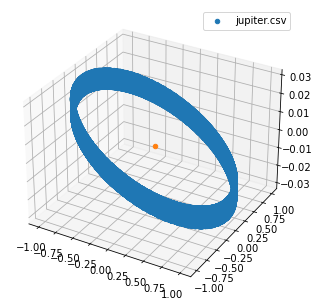

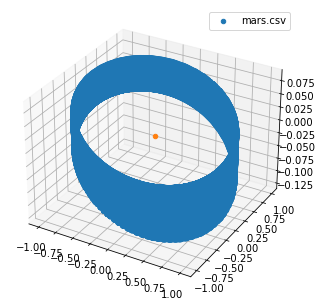

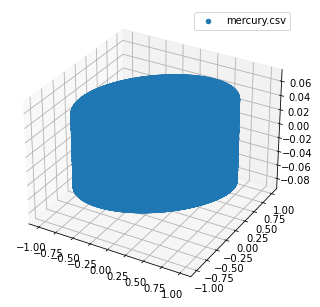

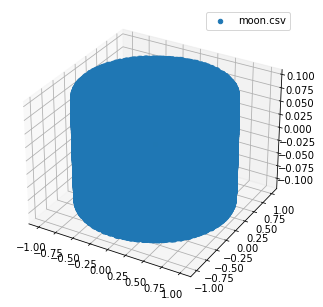

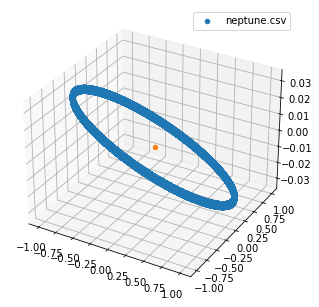

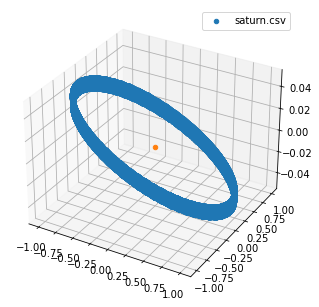

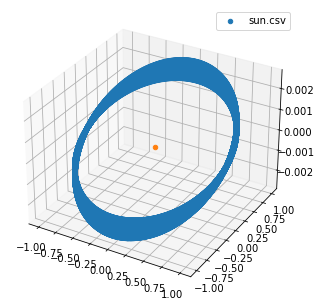

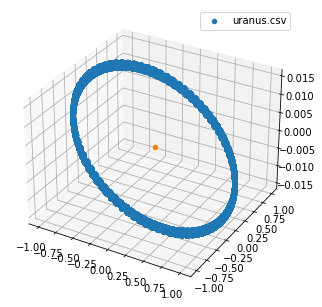

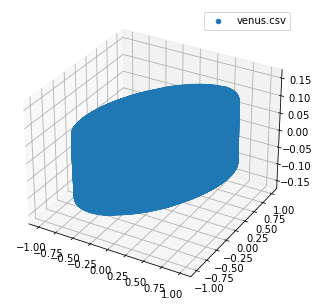

In [4]:
for file in listdir(directory):
    with open(directory + '/' + file, 'r') as f:
        reader = DictReader(f)
        old_coord = np.array([[float(row['R.A._(ICRF)']), float(row['DEC_(ICRF)'])] for row in reader], dtype=np.float64)
        
        ecliptic = SkyCoord(ra=old_coord[:,0], dec=old_coord[:,1], frame='icrs', unit='deg').transform_to(GeocentricTrueEcliptic())
        cart =  np.array([[s.x, s.y, s.z] for s in ecliptic.cartesian])
        
        fig = plt.figure()
        ax = Axes3D(fig)
        ax.scatter(cart[:,0], cart[:,1], cart[:,2])
        ax.legend([file])
        ax.scatter([0], [0], [0])
        plt.show()

In [5]:
%matplotlib notebook

venus.csv


<IPython.core.display.Javascript object>


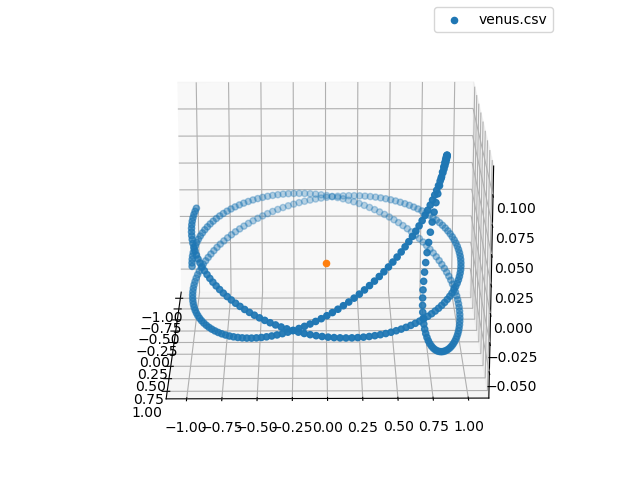

In [14]:
file = listdir(directory)[8]
print(file)
with open(directory + '/' + file, 'r') as f:
    reader = DictReader(f)
    old_coord = np.array([[float(row['R.A._(ICRF)']), float(row['DEC_(ICRF)'])] for row in reader], dtype=np.float64)[:360]

    ecliptic = SkyCoord(ra=old_coord[:,0], dec=old_coord[:,1], frame='icrs', unit='deg').transform_to(GeocentricTrueEcliptic())
    cart =  np.array([[s.x, s.y, s.z] for s in ecliptic.cartesian])
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(cart[:,0], cart[:,1], cart[:,2])
    ax.legend([file])
    ax.scatter([0], [0], [0])
    plt.show()

[ 3.11454466 -0.24558511  0.02830424]


<IPython.core.display.Javascript object>


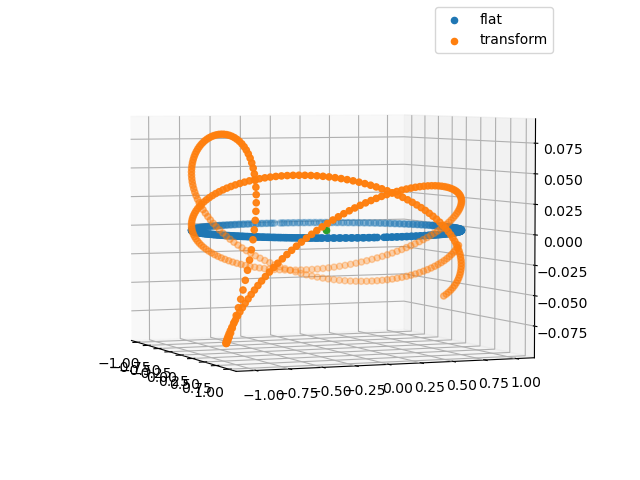

In [15]:
g = lambda x: np.sqrt(1 - x ** 2)
X = cart[:cart.shape[0] // 2,0]
Y = g(X)
X = np.hstack([X, X])
Y = np.hstack([Y, -Y])
flat = np.hstack([X[:,np.newaxis], Y[:,np.newaxis], np.zeros(Y.shape)[:,np.newaxis]])

r = R.align_vectors(flat, cart)[0]
print(r.as_rotvec())
tar = r.apply(cart)

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X, Y, np.zeros(X.shape))
# ax.scatter(cart[:,0], cart[:,1], cart[:,2])
ax.scatter(tar[:,0], tar[:,1], tar[:,2])
ax.legend(['flat', 'transform'])
ax.scatter([0], [0], [0])
plt.show()

In [ ]:
a = PolynomialFeatures(degree=2, include_bias=False)
t = a.fit_transform(cart)
data = np.hstack([t[:,:4], t[:,6:7], t[:,8:9]])
weights = np.linalg.lstsq(data, np.ones(data.shape[0]), rcond=-1)[0]
print(weights)

In [ ]:
a = PolynomialFeatures(degree=4, include_bias=False)
data = a.fit_transform(cart)
weights = np.linalg.lstsq(data, -np.ones(cart.shape[0]), rcond=-1)[0]
weights = np.array([x if abs(x) > 0.01 else 0 for x in weights])

weights *= 1/weights[-1]

feature_names = [x.replace('x0', 'x').replace('x1', 'y').replace('x2', 'z') for x in a.get_feature_names()]
eq = dict(zip(feature_names, weights))
eq_trimmed = dict([x for x in zip(feature_names, weights) if x[1]])
print('+'.join(f'{x[1]:.4} {x[0]}' for x in eq_trimmed.items()))

In [ ]:
a, b, c = np.sqrt(eq['x^2']+1), np.sqrt(eq['y^2']+1), np.sqrt(eq['z^2']+1)
print(a,b,c)
g = lambda x, y: (a * x + b * y) / -c
X, Y = np.meshgrid(np.linspace(-1, 1, 10), np.linspace(-1, 1, 100))
Z = g(X, Y)

In [ ]:
ax = Axes3D(plt.figure())
ax.scatter(cart[:,0], cart[:,1], cart[:,2])
ax.legend([file])
ax.scatter([0], [0], [0])
ax.scatter(X, Y, Z)
# ax.legend(['normal'])
ax.scatter([0], [0], [0])
plt.show()